In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from astropy.coordinates import SkyCoord
from astropy import units as u

In [6]:
df_all_model = pd.read_parquet('../scripts/nway_csc21_gaia3_full_neg_study_dis_niter200.parquet')

In [7]:
# Define the center of the Orion Nebula region
orion_center = SkyCoord(ra=83.8210 * u.deg, dec=-5.3944 * u.deg, frame='icrs')

# Create SkyCoord objects for all sources
orion_source_coords = SkyCoord(ra=df_all_model['csc21_ra'].values * u.deg, dec=df_all_model['csc21_dec'].values * u.deg, frame='icrs')

# Calculate separations
orion_separations = orion_source_coords.separation(orion_center).to(u.arcmin)

# Filter the dataframe
df_all_model['separation_from_orion'] = orion_separations
orion_sources_in_region = df_all_model[orion_separations <= 30 * u.arcmin]
orion_cscid_list = orion_sources_in_region['csc21_name'].str.replace('_', ' ').str.strip().unique().tolist()
orion_sources_in_region['num_possible_counterparts'] = orion_sources_in_region.groupby('csc21_name')['gaia3_source_id'].transform('count')


/tmp/ipykernel_2371765/3012853408.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orion_sources_in_region['num_possible_counterparts'] = orion_sources_in_region.groupby('csc21_name')['gaia3_source_id'].transform('count')


In [8]:
orion_query = orion_sources_in_region.query('num_possible_counterparts == 1').sort_values('csc21_name')

In [9]:
def get_match_label(df, p_threshold=0.35):
    """get match labels checking best matches per chandra source"""
    
    # criteria per off-axis region
    inner = (df['min_theta_mean'] < 3) & (df['separation'] <= 1.2) 
    middle = (df['min_theta_mean'].between(3, 5)) & (df['separation'] <= 2.0)
    outer = (df['min_theta_mean'] > 5) & (df['separation'] <= 2.5)
    
    # apply filters
    in_criteria = (inner | middle | outer) & (df['p_any'] > 0.5)
    df['label'] = 0
    
    # check matches per chandra source
    for csc_id in df[in_criteria]['csc21_name'].unique():
        matches = df[df['csc21_name'] == csc_id].sort_values('p_match_ind', ascending=False)
        
        # check each match in probability order
        for _, match in matches.iterrows():
            if match['p_match_ind'] > p_threshold:
                df.loc[match.name, 'label'] = 1
                break
                
    return df['label']

In [10]:
def get_match_label(df, p_threshold=0.35):
    """get match labels checking best matches per chandra source"""
    
    # criteria per off-axis region
    inner = (df['min_theta_mean'] < 3) & (df['separation'] <= 1.2) 
    middle = (df['min_theta_mean'].between(3, 5)) & (df['separation'] <= 2.0)
    outer = (df['min_theta_mean'] > 5) & (df['separation'] <= 2.5)
    
    # apply filters
    in_criteria = (inner | middle | outer) & (df['p_any'] > 0.5)
    df['label'] = 0    
    # check matches per chandra source
    for csc_id in df[in_criteria]['csc21_name'].unique():
        matches = df[df['csc21_name'] == csc_id].sort_values('p_match_ind', ascending=False)
        
        # check each match in probability order
        for _, match in matches.iterrows():
            if match['p_match_ind'] > p_threshold:
                df.loc[match.name, 'label'] = 1
                
    return df[in_criteria]

In [11]:
orion_sources_in_region['csc21_name'].nunique()

1841

In [12]:
df_in_crit = get_match_label(orion_sources_in_region)

/tmp/ipykernel_2371765/224254215.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = 0


In [13]:
df_in_crit['csc21_name'].nunique()

1407

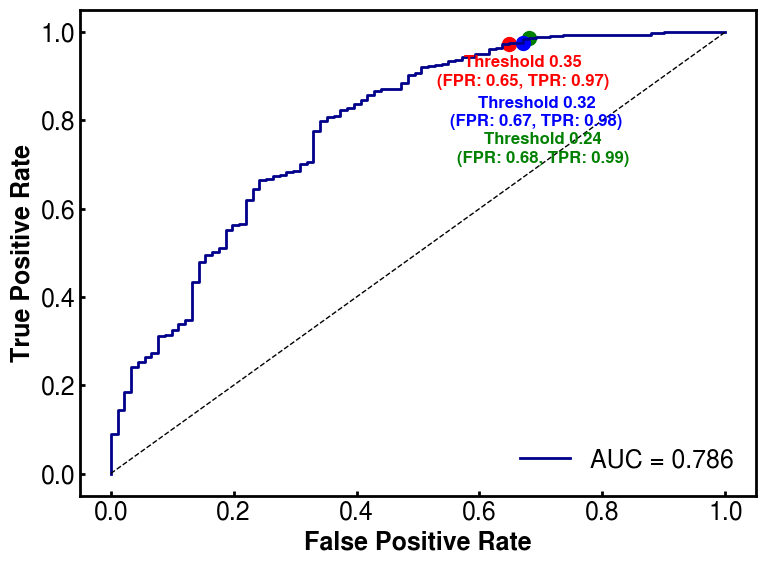

In [30]:
from sklearn.metrics import roc_curve, auc

# plotting params
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

# calculate ROC
fpr, tpr, trs = roc_curve(df_in_crit['match_flag'] == 1, df_in_crit['p_match_ind'])
roc_auc = auc(fpr, tpr)

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkblue', lw=2, 
        label=f'AUC = {roc_auc:.3f}')

# style
ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate', weight='bold')
ax.set_ylabel('True Positive Rate', weight='bold')
ax.tick_params(direction='in', which='both')
ax.legend(frameon=False, loc='lower right')

# Find the closest points to 0.35 and 0.24
closest_035 = np.argmin(np.abs(trs - 0.35))
closest_024 = np.argmin(np.abs(trs - 0.24))
closest_032 = np.argmin(np.abs(trs - 0.32))
#Annotate the closest points
ax.scatter(fpr[closest_035], tpr[closest_035], color='red', s=100, label=f'Threshold 0.35 (FPR: {fpr[closest_035]:.2f}, TPR: {tpr[closest_035]:.2f})')
ax.scatter(fpr[closest_024], tpr[closest_024], color='green', s=100, label=f'Threshold 0.24 (FPR: {fpr[closest_024]:.2f}, TPR: {tpr[closest_024]:.2f})')

# Find the closest point to 0.32
closest_032 = np.argmin(np.abs(trs - 0.32))
ax.scatter(fpr[closest_032], tpr[closest_032], color='blue', s=100, label=f'Threshold 0.32 (FPR: {fpr[closest_032]:.2f}, TPR: {tpr[closest_032]:.2f})')

# Annotate the points
ax.annotate(f'Threshold 0.35\n(FPR: {fpr[closest_035]:.2f}, TPR: {tpr[closest_035]:.2f})', 
                                                (fpr[closest_035], tpr[closest_035]), 
                                                textcoords="offset points", 
                                                xytext=(10,-30), 
                                                ha='center', color='red', fontsize=12, weight='bold')

ax.annotate(f'Threshold 0.24\n(FPR: {fpr[closest_024]:.2f}, TPR: {tpr[closest_024]:.2f})', 
                                                (fpr[closest_024], tpr[closest_024]), 
                                                textcoords="offset points", 
                                                xytext=(10,-90), 
                                                ha='center', color='green', fontsize=12, weight='bold')

ax.annotate(f'Threshold 0.32\n(FPR: {fpr[closest_032]:.2f}, TPR: {tpr[closest_032]:.2f})', 
                                                (fpr[closest_032], tpr[closest_032]), 
                                                textcoords="offset points", 
                                                xytext=(10,-60), 
                                                ha='center', color='blue', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

In [6]:
orion_sources_in_region['label'] = orion_sources_in_region.groupby('csc21_name')['p_match_ind'].transform(lambda x: ((x == x.max()) & (x > 0.35) & (orion_sources_in_region['separation'] <= 2)).astype(int))

/tmp/ipykernel_4186513/3016864526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orion_sources_in_region['label'] = orion_sources_in_region.groupby('csc21_name')['p_match_ind'].transform(lambda x: ((x == x.max()) & (x > 0.35) & (orion_sources_in_region['separation'] <= 2)).astype(int))


In [8]:
csc21_names_with_label_1 = orion_sources_in_region[orion_sources_in_region['label'] == 1]['csc21_name'].unique()
csc21_names_with_label_1

array(['2CXO J053346.0-053425', '2CXO J053354.5-053159',
       '2CXO J053357.8-053626', ..., '2CXO J053617.0-051142',
       '2CXO J053618.9-051827', '2CXO J053621.3-052014'], dtype=object)

In [9]:
# Filter the dataframe to include only sources with a potential match
matched_sources = orion_sources_in_region[orion_sources_in_region['csc21_name'].isin(csc21_names_with_label_1)]

In [7]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 50})
    plt.title(title, fontsize=26)
    plt.ylabel('NWAY label', fontsize=26)
    plt.xlabel('Predicted label', fontsize=26)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.show()
    
    # percentage
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', annot_kws={"size": 50})
    plt.title(title + ' (Percentage)', fontsize=26)
    plt.ylabel('NWAY label', fontsize=26)
    plt.xlabel('Predicted label', fontsize=26)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.show()

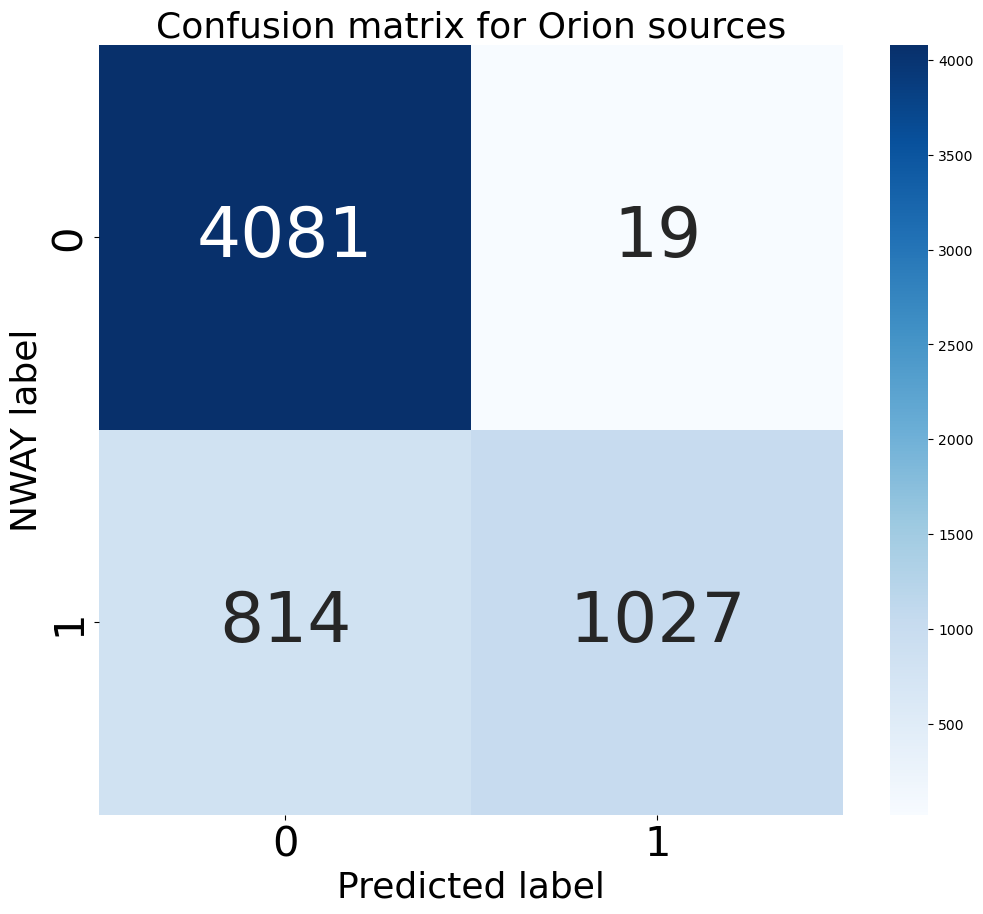

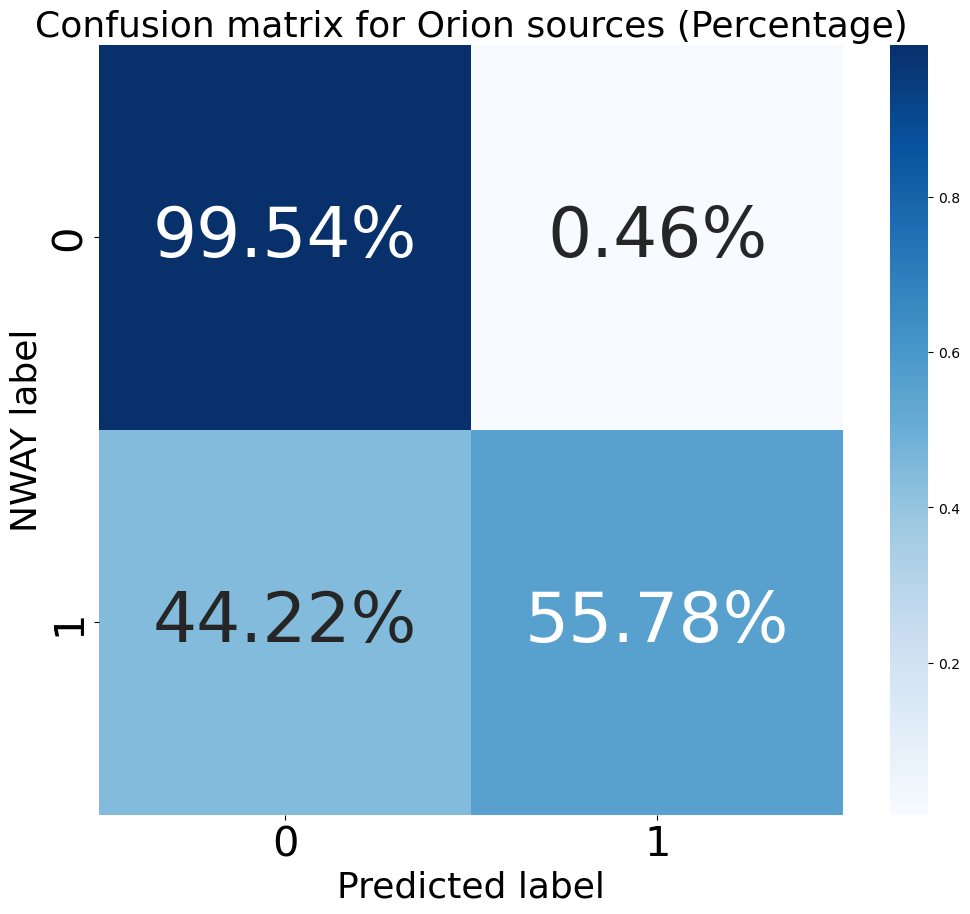

In [10]:
y_true = (orion_sources_in_region['match_flag'] == 1 ).astype(int)
y_pred = orion_sources_in_region['label']

plot_confusion_matrix(y_true, y_pred, 'Confusion matrix for Orion sources')

In [12]:
# for each pair, find if it's the best match for both sources
orion_sources_in_region['best_for_xray'] = orion_sources_in_region.groupby('csc21_name')['p_match_ind'].transform('max') == orion_sources_in_region['p_match_ind']
orion_sources_in_region['best_for_gaia'] = orion_sources_in_region.groupby('gaia3_source_id')['p_match_ind'].transform('max') == orion_sources_in_region['p_match_ind']

/tmp/ipykernel_4186513/928954300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orion_sources_in_region['best_for_xray'] = orion_sources_in_region.groupby('csc21_name')['p_match_ind'].transform('max') == orion_sources_in_region['p_match_ind']
/tmp/ipykernel_4186513/928954300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orion_sources_in_region['best_for_gaia'] = orion_sources_in_region.groupby('gaia3_source_id')['p_match_ind'].transform('max') == orion_sources_in_region['p_match_ind']


In [ ]:
gaia_matched = matched_sources.gaia3_source_id.unique()
# look at these sources in df_all_model
df_all_model.query('gaia3_source_id in @matched_sources.gaia3_source_id.unique()')

array(['3209415239649017856', '3209415759341159808',
       '3209415759342173696', ..., '3017368530095330432',
       '3017356602958232064', '3017356607266117760'], dtype=object)

In [19]:
non_best_matches = matched_sources[
   (matched_sources.match_flag != 1) & 
   (matched_sources.label == 1)
]
gaia_ids_non_best = non_best_matches.gaia3_source_id.unique()

In [22]:
matches_to_check = orion_sources_in_region[
   (orion_sources_in_region.gaia3_source_id.isin(gaia_ids_non_best)) &
   (orion_sources_in_region.label == 0) & 
   (orion_sources_in_region.separation <= 2)
]

In [38]:
matches_to_check

,csc21_name,csc21_ra,csc21_dec,csc21_errmaj,csc21_errmin,csc21_errpa,hard_hs,hard_hm,hard_hm_lolim,hard_hm_hilim,...,p_i,match_flag,count,sqrt(pmra^2+pmdec^2),p_match_ind,separation_from_orion,num_possible_counterparts,label,best_for_xray,best_for_gaia
1060041,2CXO J053527.4-051709,83.864471,-5.285991,0.159315,0.134805,94.0,-0.242349,0.017489,-0.150531,0.189257,...,1.0,1,6,3.278312,0.933465,7.003824,6,0,False,False


In [83]:
src_interest = orion_sources_in_region.query('gaia3_source_id == "3017367258785044224" and separation <= 5')

In [89]:
src_interest

,csc21_name,csc21_ra,csc21_dec,csc21_errmaj,csc21_errmin,csc21_errpa,hard_hs,hard_hm,hard_hm_lolim,hard_hm_hilim,...,p_i,match_flag,count,sqrt(pmra^2+pmdec^2),p_match_ind,separation_from_orion,num_possible_counterparts,label,best_for_xray,best_for_gaia
1060034,2CXO J053527.3-051712,83.863770,-5.286752,0.232845,0.187910,96.599998,0.082448,0.228607,-0.217989,0.615240,...,0.000000e+00,0,4,3.278312,0.809235,6.945900,4,0,False,False
1060041,2CXO J053527.4-051709,83.864471,-5.285991,0.159315,0.134805,94.000000,-0.242349,0.017489,-0.150531,0.189257,...,1.000000e+00,1,6,3.278312,0.933465,7.003824,6,0,False,False
1060046,2CXO J053527.4-051711,83.864449,-5.286551,0.302290,0.232845,99.400002,-0.742036,0.279825,-0.217989,0.690194,...,1.233886e-13,0,4,3.278312,0.906157,6.972140,4,1,True,False


In [92]:
orion_sources_in_region[orion_sources_in_region['csc21_name'] == '2CXO J053527.4-051711'][['min_theta_mean', 'gaia3_source_id', 'p_match_ind', 'separation', 'label', 'match_flag']]

,min_theta_mean,gaia3_source_id,p_match_ind,separation,label,match_flag
1060044,2.239638,3017366502870800512,0.892640,12.204260,0,0
1060045,2.239638,3017367258772449920,0.717550,2.485025,0,0
1060046,2.239638,3017367258785044224,0.906157,1.889382,1,0
1060047,2.239638,3017367258785044480,0.830495,0.315014,0,1


In [81]:
import matplotlib.pyplot as plt
from astroquery.hips2fits import hips2fits

# get central coords from reference match
ref = orion_sources_in_region.query(
   'gaia3_source_id == "3017367258785044224" and label == 1'
).iloc[0]

# get jwst miri image
hips = 'https://skies.esac.esa.int/JWST/MIRI_Imaging/'
result = hips2fits.query(
   hips=hips,
   width=800, height=800,
   ra=ref.csc21_ra*u.deg,
   dec=ref.csc21_dec *u.deg,
   fov=0.004 *u.deg,
   projection='TAN'
)

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

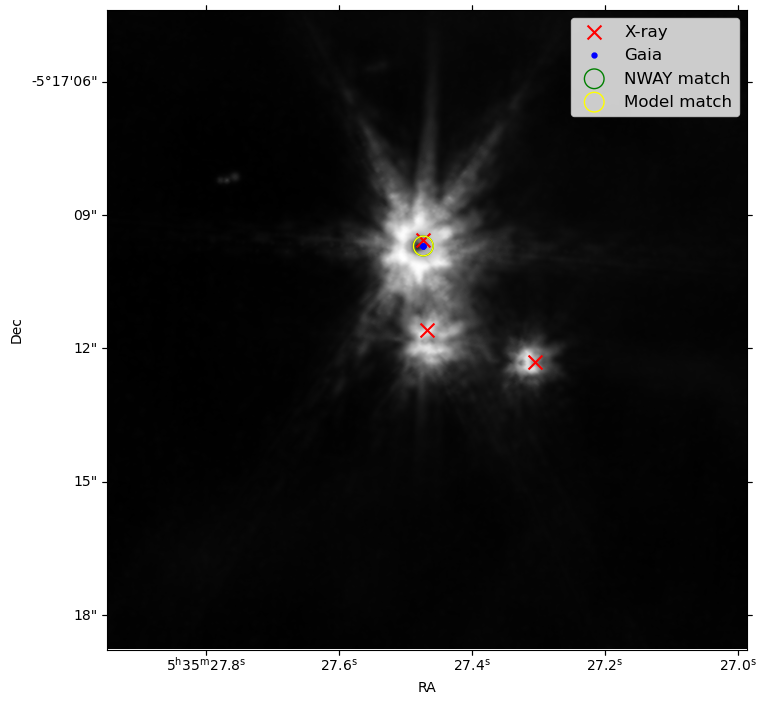

In [82]:
wcs = WCS(result[0].header)

fig = plt.figure(figsize=(8,8))
ax = WCSAxes(fig, [0.1,0.1,0.8,0.8], wcs=wcs)
fig.add_axes(ax)

# plot background image
ax.imshow(result[0].data, cmap='gray', origin='lower')

# plot x-ray sources 
ax.scatter(
   src_interest.csc21_ra,
   src_interest.csc21_dec,
   transform=ax.get_transform('world'),
   color='red', marker='x', s=100, label='X-ray'
)

# plot gaia sources
ax.scatter(
   src_interest.gaia3_ra,
   src_interest.gaia3_dec,
   transform=ax.get_transform('world'),
   color='blue', marker='.', s=50, label='Gaia'
)

# highlight NWAY match
nway_match = src_interest.query('match_flag == 1').iloc[0]
ax.scatter(
   nway_match.gaia3_ra,
   nway_match.gaia3_dec,
   transform=ax.get_transform('world'),
   color='green', marker='o', s=200, facecolors='none',
   label='NWAY match'
)

# highlight model match
model_match = src_interest.query('p_match_ind == p_match_ind.max()').iloc[0]
ax.scatter(
   model_match.gaia3_ra,
   model_match.gaia3_dec, 
   transform=ax.get_transform('world'),
   color='yellow', marker='o', s=200, facecolors='none',
   label='Model match'
)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.legend(fontsize=12)
plt.show()

In [ ]:
orion_sources_in_region[orion_sources_in_region['best_for_xray'] == 1].query('p_match_ind <= 0.35')

In [82]:
# how many matches remain vs original
print(f"Original pairs: {len(orion_sources_in_region)}")
print(f"Clean matches: {len(clean_matches)}")

# compare to NWAY's choices
nway_matches = orion_sources_in_region[orion_sources_in_region['match_flag']==1]
overlap = len(set(clean_matches.index) & set(nway_matches.index))
print(f"Overlap with NWAY: {overlap}")

Original pairs: 5941
Clean matches: 1162
Overlap with NWAY: 1000


In [44]:
mismatched_rows = matched_sources[y_true != y_pred]
#mismatched_rows[['csc21_name', 'csc21_ra', 'csc21_dec', 'gaia3_source_id', 'p_any', 'p_i', 'p_match_ind', 'label', 'match_flag', 'separation_from_orion', 'num_possible_counterparts']]

In [45]:
mismatched_rows

,csc21_name,csc21_ra,csc21_dec,csc21_errmaj,csc21_errmin,csc21_errpa,hard_hs,hard_hm,hard_hm_lolim,hard_hm_hilim,...,p_i,match_flag,count,sqrt(pmra^2+pmdec^2),p_match_ind,separation_from_orion,num_possible_counterparts,label,best_for_xray,best_for_gaia
1054474,2CXO J053354.5-053159,83.477318,-5.533226,1.017165,0.710790,46.000000,0.018738,-0.258588,-0.612742,0.011868,...,3.882515e-01,2,2,0.534150,0.661057,22.152802,2,1,True,True
1054475,2CXO J053354.5-053159,83.477318,-5.533226,1.017165,0.710790,46.000000,0.018738,-0.258588,-0.612742,0.011868,...,6.117485e-01,1,2,NaN,0.092227,22.152802,2,0,False,True
1054700,2CXO J053443.1-054439,83.679588,-5.744310,0.400330,0.310460,123.400002,-0.712055,-0.156152,-0.415365,0.078076,...,1.411789e-01,0,2,1.686202,0.919876,22.629261,2,1,True,True
1054701,2CXO J053443.1-054439,83.679588,-5.744310,0.400330,0.310460,123.400002,-0.712055,-0.156152,-0.415365,0.078076,...,8.588212e-01,1,2,NaN,0.101962,22.629261,2,0,False,True
1054839,2CXO J053452.7-052753,83.719856,-5.464969,0.122550,0.122550,81.599998,-0.353529,-0.173641,-0.193004,-0.154279,...,3.222544e-13,0,2,2.457287,0.874533,7.377383,2,1,True,True
1054840,2CXO J053452.7-052753,83.719856,-5.464969,0.122550,0.122550,81.599998,-0.353529,-0.173641,-0.193004,-0.154279,...,1.000000e+00,1,2,2.904803,0.714241,7.377383,2,0,False,True
1054943,2CXO J053457.7-052350,83.740479,-5.397514,0.122550,0.122550,0.000000,-0.614616,-0.099938,-0.131793,-0.069332,...,1.121039e-44,0,2,0.642165,0.928543,4.813454,2,1,True,True
1054944,2CXO J053457.7-052350,83.740479,-5.397514,0.122550,0.122550,0.000000,-0.614616,-0.099938,-0.131793,-0.069332,...,1.000000e+00,1,2,0.666841,0.888319,4.813454,2,0,False,True
1054989,2CXO J053500.1-052301,83.750473,-5.383909,0.122550,0.118465,67.300003,-0.552155,-0.148657,-0.191755,-0.104310,...,2.056966e-03,0,4,NaN,0.823822,4.259632,4,1,True,True
1054991,2CXO J053500.1-052301,83.750473,-5.383909,0.122550,0.118465,67.300003,-0.552155,-0.148657,-0.191755,-0.104310,...,9.979430e-01,1,4,NaN,0.820955,4.259632,4,0,False,True


In [46]:
mismatched_rows.to_csv('../out_data/validation/mismatched_orion_sources_rows_sep2.csv', index=False)

In [25]:
len(mismatched_rows['csc21_name'].unique())

627

In [ ]:
mismatched_csc21_names = mismatched_rows['csc21_name'].unique()
mismatched_full_df = df_all_model[df_all_model['csc21_name'].isin(mismatched_csc21_names)]
mismatched_full_df  

,csc21_name,csc21_ra,csc21_dec,csc21_errmaj,csc21_errmin,csc21_errpa,hard_hs,hard_hm,hard_hm_lolim,hard_hm_hilim,...,dist_bayesfactor,dist_post,p_single,p_any,p_i,match_flag,count,sqrt(pmra^2+pmdec^2),p_match_ind,separation_from_orion
1054474,2CXO J053354.5-053159,83.477318,-5.533226,1.017165,0.710790,46.000000,0.018738,-0.258588,-0.612742,0.011868,...,10.798160,9.908483e-01,9.908483e-01,0.996427,0.388252,2,2,0.534150,0.661057,22.152802
1054475,2CXO J053354.5-053159,83.477318,-5.533226,1.017165,0.710790,46.000000,0.018738,-0.258588,-0.612742,0.011868,...,10.995620,9.941723e-01,9.941723e-01,0.996427,0.611749,1,2,NaN,0.092227,22.152802
1054498,2CXO J053405.9-052241,83.524857,-5.378230,0.800660,0.690365,21.400000,0.261087,0.026234,-0.055590,0.101811,...,-53.870602,0.000000e+00,0.000000e+00,0.929077,0.000000,0,3,6.913919,0.278364,17.716681
1054499,2CXO J053405.9-052241,83.524857,-5.378230,0.800660,0.690365,21.400000,0.261087,0.026234,-0.055590,0.101811,...,8.321090,2.652136e-01,2.652136e-01,0.929077,0.027553,0,3,2.120180,0.944319,17.716681
1054500,2CXO J053405.9-052241,83.524857,-5.378230,0.800660,0.690365,21.400000,0.261087,0.026234,-0.055590,0.101811,...,9.868788,9.272142e-01,9.272142e-01,0.929077,0.972447,1,3,1.718079,0.936216,17.716681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060712,2CXO J053619.8-051426,84.082901,-5.240759,3.153620,3.153620,0.000000,0.502186,0.724547,0.489069,0.916302,...,8.912745,5.849905e-01,5.849905e-01,0.586404,0.994193,1,2,0.996231,0.490257,18.160187
1060716,2CXO J053624.5-053450,84.102219,-5.580619,6.956755,3.754115,51.200001,-0.137414,-0.243598,-0.527795,-0.021861,...,9.427318,8.217339e-01,8.217339e-01,0.900415,0.509817,1,2,2.769930,0.388983,20.172741
1060717,2CXO J053624.5-053450,84.102219,-5.580619,6.956755,3.754115,51.200001,-0.137414,-0.243598,-0.527795,-0.021861,...,9.410260,8.159078e-01,8.159078e-01,0.900415,0.490183,2,2,1.195963,0.948562,20.172741
1060721,2CXO J053630.0-052006,84.125053,-5.335166,0.388075,0.167485,173.600006,-0.515928,-0.187383,-0.222986,-0.150531,...,-53.111420,0.000000e+00,0.000000e+00,0.000000,0.000000,0,2,1.473365,0.949671,18.507790


In [86]:
mismatched_full_df.to_csv('../out_data/validation/orion_mismatched_full_df.csv', index=False)

In [87]:
orion_sources_in_region.to_csv('../out_data/validation/orion_sources_in_region.csv', index=False)

In [78]:
mismatched_rows.csc21_name.sample(1).values[0]

'2CXO J053522.8-052226'

In [26]:
src_interest = df_all_model[df_all_model['csc21_name'] == '2CXO J053523.0-052836']
src_interest[['csc21_name', 'csc21_ra', 'csc21_dec', 'gaia3_source_id', 'p_any', 'p_i', 'p_match_ind', 'match_flag', 'separation']]

,csc21_name,csc21_ra,csc21_dec,gaia3_source_id,p_any,p_i,p_match_ind,match_flag,separation
1059673,2CXO J053523.0-052836,83.846169,-5.476952,3017359386099075072,0.997648,4.779405e-31,0.801531,0,3.648854
1059674,2CXO J053523.0-052836,83.846169,-5.476952,3017359390406492288,0.997648,1.000000e+00,0.186806,1,0.487666
1059675,2CXO J053523.0-052836,83.846169,-5.476952,3017359459125972736,0.997648,0.000000e+00,0.761034,0,12.622300


In [74]:
src_interest['p_i'] * src_interest['p_match_ind']

1059673    3.830842e-31
1059674    1.868058e-01
1059675    0.000000e+00
dtype: float64